# Exploratory Analysis of a small version of the data set #


In [186]:
# import useful packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set()

mpl.rcParams['lines.linewidth']=1.5
mpl.rcParams['xtick.labelsize']=13
mpl.rcParams['ytick.labelsize']=13
mpl.rcParams['axes.labelsize']=15
mpl.rcParams['axes.labelweight']='heavy'



import os
import sys

Add our own packages to the system path, and import packages

In [16]:
src_dir = os.path.join(os.path.dirname(os.getcwd()),'adfraud')
sys.path.append(src_dir)

#### Define where the data is stored, and the data file to load, and read data into a pandas DataFrame ####

In [17]:
data_dir = os.path.join(os.path.dirname(os.getcwd()),'data')

In [18]:
data_filename = 'train_sample.csv'
data_location = os.path.join(data_dir,data_filename)
ad_data = pd.read_csv(data_location)

Let's start getting a very rough overview of the data

First looking at the cloumn headings, and then the forst few entries of data to get a feel for the data and data_types in the columns

In [22]:
# get a list of the cloumn names
list(ad_data)

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'attributed_time',
 'is_attributed']

In [21]:
# the first 4 rows of data
ad_data.head(4)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0


In [35]:
ad_data.shape

(100000, 8)

##### Some initial thoughts: #####

* The ip adresses don't look like normal ip addresses - we probably cannot geotag them (which might have been useful)

* attributed_time only exists if there is attribution  - it is therfore also like the label is_attributed - and so would be unfoar to use for training

* click_time can probably be converted into 1hour or half-hour periods. i.e replace all events with time between 08:00 and 09:00 with 8:00, regardless of the sepecific day.

* All fields except time seem to be categorical. Follwing the above suggestion with the time will lead to the click_time being best treated as nominal, although given a later or earlier time is not neccessarily better/worse and that time occurs on a circle, not linearly, it may be best to treat the field as categorical data.

   - treating all the data as categorical could lead to large dimensionality, particularly if use one-hot encoding, it may be that using a hash encoding is better. 
   - for categorical data there is also the worry that future out-of-sample data won't be predicted well by whatever ML model we build.


### check the balanced/imbalanced nature of this dataset ###

In [25]:
ad_data['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

So, the data set is clearly imbalanced, there are for more 0 labelled than 1 labelled data.

This is already surprising to me - that means most traffic was either fraudulent or potentially so (no downlaod follwing a click)

Imprtantly for analysis - this means we have to be careful about how we select data for training from the data set
we may also want to consider whether we care more about sensitivity or specicifity from our model. 

### Let's start to look into the data itself for some beginning clues ###

In [38]:
no_uniq_ips = ad_data['ip'].nunique()
print("number of unique ips = ",no_uniq_ips)
print("fraction of unique ips vs all all ips = ",no_uniq_ips/len(ad_data.index))

number of unique ips =  34857
fraction of unique ips vs all all ips =  0.34857


In [40]:
print(ad_data['ip'].value_counts().head())
print(ad_data['ip'].value_counts().tail())

5348     669
5314     616
73487    439
73516    399
53454    280
Name: ip, dtype: int64
125982    1
5153      1
177205    1
60478     1
92122     1
Name: ip, dtype: int64


[669 616 439 ...   1   1   1]


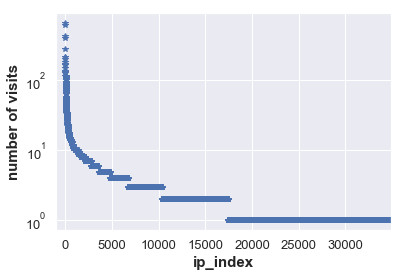

In [187]:
ip_counts = ad_data['ip'].value_counts().to_numpy()
print(ip_counts)
plt.semilogy((ip_counts), '*')
plt.xlim([-1000,len(ip_counts)])

plt.xlabel('ip_index')
plt.ylabel('number of visits')

plt.show()

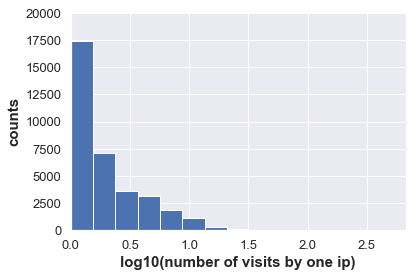

In [189]:
plt.hist(np.log10(ip_counts),bins=15)
plt.xlim([0.0,np.amax(np.log10(ip_counts))])
plt.ylim([-0.0,20000])

plt.xlabel('log10(number of visits by one ip)')
plt.ylabel('counts')

plt.show()

We can clearly see that most ip addresses make only a handful of clicks, but there are a small number of ips who make a few hundred clicks.

factors that may affect this are how frequent that clicks occur. If we were predicting in real time and a new user shows up making many clicks, we may want to keep track of those clicks - it may be that different temporal profiles for clicking patterns can signify true vs false actors.

In [94]:
ad_data_attr=ad_data[ad_data['is_attributed']==1.0]
ad_data_attr.head()
ad_data_attr['ip'].value_counts().head()

5348      3
5314      3
272894    1
11967     1
65214     1
Name: ip, dtype: int64

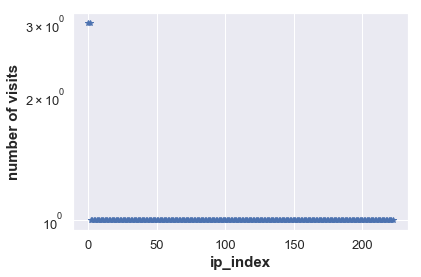

In [190]:
ip_counts = ad_data_attr['ip'].value_counts().to_numpy()
plt.semilogy(ip_counts, '*')
plt.xlabel('ip_index')
plt.ylabel('number of visits')

plt.show()

In [100]:
ad_data_notattr=ad_data[ad_data['is_attributed']==0.0]
ad_data_notattr.head()
ad_data_notattr['ip'].value_counts().head()

5348     666
5314     613
73487    439
73516    399
53454    280
Name: ip, dtype: int64

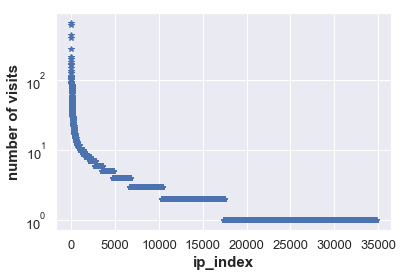

In [191]:
ip_counts = ad_data_notattr['ip'].value_counts().to_numpy()
plt.semilogy(ip_counts, '*')
plt.xlabel('ip_index')
plt.ylabel('number of visits')

plt.show()

So, while we can proabably treat any ip we've seen many times before as fraudulent, the challenge is then, how do we seperate out the fraudulent cases where the ip has only been seen a handful of times. (I would guess this is is bots using vpn/proxy etc to a network of ips obtained nefariously).

Since there are many more bad than good actors, cutting out the high usage ips will remove a lot of fraudulent users, but there will still be many more fraudulent than real users.


To get a better predictor, we're clearly going to need to use the rest of the data at our disposal.

I want to look at how many categories exist in the other data fields, to get a sense of the dimensionality of the problem at hand.

In [104]:
categoricals=['app','device','os','channel']
for c in categoricals:
    no_uniq = ad_data[c].nunique()
    print("number of unique " + c + " = ",no_uniq)


number of unique app =  161
number of unique device =  100
number of unique os =  130
number of unique channel =  161


Number of unique "app" and unique "channel" are the same - some info overlap?

I would guess that device and os contain a lot of information overlap. i.e all iphone models running some ios version, samsung running android etc. but then, maybe shouldn't discount this in case say some brands of phone running a certain os is unusual and is actually a sign for bots or something.


#### DEVICE and OS fields #### 

In [161]:
dev_os = ad_data.groupby(['device','os']).size().reset_index(name='counts')

In [139]:
ad_data['os'].value_counts().head(10)

19    23870
13    21223
17     5232
18     4830
22     4039
10     2816
8      2775
6      2520
15     2396
20     2347
Name: os, dtype: int64

In [143]:
ad_data['device'].value_counts().head(10)

1       94338
2        4345
0         541
3032      371
3543      151
3866       93
59         12
6           8
16          7
5           7
Name: device, dtype: int64

some devices, and some os's, get used a lot more than others. Which makes sense. Are the os's used by the most used devices different from those used by other devices?

In [158]:
most_used_dev = ad_data[ad_data['device'].isin([0,1,2])][['device','os']]
print("no unique os for most used devices = ", most_used_dev['os'].nunique())
print(most_used_dev['os'].unique())
most_used_dev['os'].value_counts().head(10)

no unique os for most used devices =  125
[ 13  17  19   1  25  22  20   2  90  10  18  40  15  27  23  53  49  37
  26  41   8  11   9  14  28  47   3   6  97   4  31  16  30  32  12  46
  65  55  29  42  39  34  79  35  44   7   0  36  99  43  64  58  50  24
  66  57 109  70  98 836  56 108  76 137  48   5  38  63 100  62  21  96
  88  73  74 138  52  61 172  59  81 102 748  77 866  78  60 153  80 118
  69  85 151  68 178 192 135 198  83 112  67 132  71 607 142 117 111 168
 106 110 129 127 107 152 155 133  92 196  87 174 207 184 114 185 193]


19    23869
13    21221
17     5232
18     4830
22     4038
10     2816
8      2775
6      2520
15     2396
20     2346
Name: os, dtype: int64

In [160]:
least_used_dev = ad_data[~ad_data['device'].isin([0,1,2])][['device','os']]
print("no unique os for least used devices = ", least_used_dev['os'].nunique())
print(least_used_dev['os'].unique())
least_used_dev['os'].value_counts().head(10)

no unique os for least used devices =  26
[866 607 748  21  24   0  38  23  29  45  84  13  50  59 113  76  20  12
   5  22  19 199   9 116  67  52]


607    371
748    149
866     93
24      44
0       39
29      24
38      13
21      12
45       7
9        3
Name: os, dtype: int64

So, the most used (top 3) devices use quite a different set of os's to the rest of the devices. All but one row in the table of os 19 were for the top 3 devices.  

This could just be due to prevalence of certin brands and associated id's rather than a suggestion that there is a strong predictor for fraud associated with this info. But it could give the option for reducing dimension due to linked info.


In [165]:
os19 = ad_data[ad_data.os==19]
os19['is_attributed'].value_counts()

0    23829
1       41
Name: is_attributed, dtype: int64

Use of os '19' doesn't seem to be in any way a predictor of ad fraud - rembering that the data set is heavily skewed towards unattributed clicks.

Since we are doing an initial quick scan through the data, I'll leave this here and keep it in mind as an area for development during model building. 

Now, we go on to look at other features

#### APP and CHANNEL fields ####

let's look to see how the app and channel field are related. 

In [287]:
ad_data['channel'].value_counts().head(10)

280    8114
245    4802
107    4543
477    3960
134    3224
259    3130
265    3013
153    2954
178    2936
121    2472
Name: channel, dtype: int64

In [288]:
ad_data['app'].value_counts().head(10)

3     18279
12    13198
2     11737
9      8992
15     8595
18     8315
14     5359
1      3135
13     2422
8      2004
Name: app, dtype: int64

In [218]:
modal_channel = ad_data['channel'].mode().iloc[0]

print(ad_data[ad_data['channel']==modal_channel]['app'].value_counts())

print(ad_data[ad_data['channel']==modal_channel]['device'].value_counts())

print(ad_data[ad_data['channel']==modal_channel]['os'].value_counts().head(10))

print(ad_data[ad_data['channel']==modal_channel]['ip'].value_counts().head(10))

print(ad_data[ad_data['channel']==modal_channel]['is_attributed'].value_counts())



3     7833
17     281
Name: app, dtype: int64
1     7827
2      285
59       2
Name: device, dtype: int64
19    1943
13    1767
17     461
18     439
22     316
8      300
10     290
20     233
6      226
15     197
Name: os, dtype: int64
5348      49
5314      37
53454     23
73516     22
73487     20
114276    20
137052    17
17149     16
44744     12
26995     12
Name: ip, dtype: int64
0    8112
1       2
Name: is_attributed, dtype: int64


In [213]:
modal_app = ad_data['app'].mode().iloc[0]
print(ad_data[ad_data['app']==modal_app]['channel'].value_counts())
print(ad_data[ad_data['app']==modal_app]['device'].value_counts())


280    7833
137     957
424     722
489     703
480     684
409     681
442     666
115     633
205     613
211     579
173     565
379     557
130     435
135     426
19      422
452     382
371     242
153     235
466     231
417     198
402     149
317     120
30       70
182      67
421      46
113      38
110       9
404       7
456       4
353       3
114       1
22        1
Name: channel, dtype: int64
1     17656
2       613
5         7
59        3
Name: device, dtype: int64


The most used app uses many channels (although mostly the overall modal channel). The modal channel uses only two apps.

In [220]:
print(ad_data_attr['channel'].value_counts().head(10))
print(ad_data_notattr['channel'].value_counts().head(10))

213    72
113    31
21     19
101    13
274    12
347    11
282     5
171     5
243     5
5       5
Name: channel, dtype: int64
280    8112
245    4802
107    4542
477    3960
134    3223
259    3130
265    3011
153    2954
178    2936
121    2471
Name: channel, dtype: int64


In [221]:
print(ad_data_attr['app'].value_counts().head(10))
print(ad_data_notattr['app'].value_counts().head(10))

19    70
35    27
29    22
10    18
5     14
45    11
9      8
72     6
18     5
3      4
Name: app, dtype: int64
3     18275
12    13197
2     11737
9      8984
15     8593
18     8310
14     5359
1      3135
13     2422
8      2000
Name: app, dtype: int64


In [222]:
print(ad_data_attr['device'].value_counts().head(10))
print(ad_data_notattr['device'].value_counts().head(10))

1     146
0      52
97      3
16      3
2       2
21      2
50      1
4       1
6       1
30      1
Name: device, dtype: int64
1       94192
2        4343
0         489
3032      371
3543      151
3866       93
59         12
5           7
6           7
40          6
Name: device, dtype: int64


In [223]:
print(ad_data_attr['os'].value_counts().head(10))
print(ad_data_notattr['os'].value_counts().head(10))

19    41
0     26
24    26
13    25
29    11
21     8
17     6
27     6
22     6
7      5
Name: os, dtype: int64
19    23829
13    21198
17     5226
18     4826
22     4033
10     2813
8      2775
6      2518
15     2392
20     2344
Name: os, dtype: int64


It looks like the data will be easier to seperate into attributed/not attributed on the basis of app and channel as oppposed to device and os - since there seems to be a lot of overlap of users using the same device/os for not/is attributed cases.

### timing of use ###

I'm going to put time into a condensed hourly format (ie all time 08->09 at 08:00, ignoring the exact day, as well as mins and secs).

Although, side note:
For a real-time analysis system, I would I imagine it would be beneficial to include recent dynamics into the model. e.g. how has a particular ip acted in the last week - could have clicked on ads and not download becuase unsure, but eventually will download or something like that - there may be different patterns for those users compared to fraudulent cases.

In [248]:
ad_data['click_time'].head(10)

0    2017-11-07 09:30:38
1    2017-11-07 13:40:27
2    2017-11-07 18:05:24
3    2017-11-07 04:58:08
4    2017-11-09 09:00:09
5    2017-11-09 01:22:13
6    2017-11-09 01:17:58
7    2017-11-07 10:01:53
8    2017-11-08 09:35:17
9    2017-11-08 12:35:26
Name: click_time, dtype: object

In [249]:
pd.to_datetime(ad_data['click_time'],format='%Y-%m-%d %H:%M:%S').head(10)

0   2017-11-07 09:30:38
1   2017-11-07 13:40:27
2   2017-11-07 18:05:24
3   2017-11-07 04:58:08
4   2017-11-09 09:00:09
5   2017-11-09 01:22:13
6   2017-11-09 01:17:58
7   2017-11-07 10:01:53
8   2017-11-08 09:35:17
9   2017-11-08 12:35:26
Name: click_time, dtype: datetime64[ns]

In [250]:
# adjust the all rows in click_time into datetime format
ad_data['click_time'] = pd.to_datetime(ad_data['click_time'],format='%Y-%m-%d %H:%M:%S')

In [254]:
# adjust all rows so that click time is just the hour in which click happened
ad_data['click_time'] = ad_data['click_time'].dt.hour 

Now, make two tables, for attributed and unattributed clicks

In [305]:
ad_data_attr = ad_data[ad_data['is_attributed']==1]
ad_data_notattr = ad_data[ad_data['is_attributed']==0]

In [306]:
attr_click_cts = ad_data_attr['click_time'].value_counts().sort_index()
notattr_click_cts = ad_data_notattr['click_time'].value_counts().sort_index()

In [307]:
attr_click_cts.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20,
            21, 22, 23],
           dtype='int64')

In [308]:
attr_click_cts

0     13
1     15
2     10
3     15
4     10
5     15
6     12
7     13
8     13
9     10
10    16
11    10
12    14
13    10
14    17
15     9
17     2
18     2
20     2
21     3
22     3
23    13
Name: click_time, dtype: int64

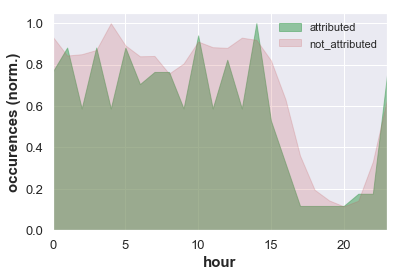

In [309]:
def max_norm(a):
    return a/np.amax(a)

plt.fill_between(attr_click_cts.index,0.0,max_norm(attr_click_cts),alpha=0.6,color='g',label='attributed')
plt.fill_between(notattr_click_cts.index,0.0,max_norm(notattr_click_cts),alpha=0.2,color='r',label='not_attributed')
plt.legend(frameon=False)
plt.xlabel('hour')
plt.ylabel('occurences (norm.)')

plt.xlim([0.0,23])
plt.ylim([0.0,1.05])

plt.show()

The temporal dependence of clicks doesn't look like a great independent predictor for fraudluent clicks.
It could be that it performs well when paired with the other features though.

It seems a little confusing that all users seems to click throughout the night - but this could be due to the timezone being used not being the one used in the country under investigation. 

The spiky nature of the attributed data compared with the not attributed data is simply due to fewer data points.

Our model:

do we actually want to look through the rows a few at a time - to look at temporal profile of users or perhaps apps/channels - and ban particular ip/app/channels as their stats look weird - and ben them for either ever or some period of time?

In [310]:
modal_ip =  ad_data['ip'].mode().iloc[0]
ad_data_notattr_maxip = ad_data[(ad_data['is_attributed']==0) & (ad_data['ip']==modal_ip)]

In [311]:
notattr_maxip_click_cts = ad_data_notattr_maxip['click_time'].value_counts().sort_index()

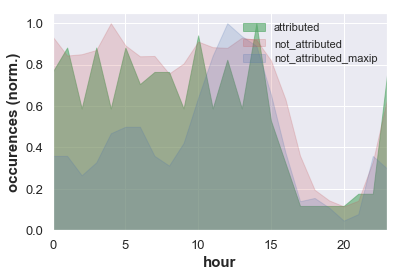

In [312]:
plt.fill_between(attr_click_cts.index,0.0,max_norm(attr_click_cts),alpha=0.6,color='g',label='attributed')
plt.fill_between(notattr_click_cts.index,0.0,max_norm(notattr_click_cts),alpha=0.2,color='r',label='not_attributed')
plt.fill_between(notattr_maxip_click_cts.index,0.0,max_norm(notattr_maxip_click_cts),alpha=0.2,color='b',label='not_attributed_maxip')
plt.legend(frameon=False)
plt.xlabel('hour')
plt.ylabel('occurences (norm.)')

plt.xlim([0.0,23])
plt.ylim([0.0,1.05])

plt.show()

The modal ip in the data set follows a time trend different from the average, but then each user will likely have a different trend from 
the overall average